In [9]:
import pandas as pd
import numpy as np
import os
import keras
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
CATEGORIES = ['cats', 'dogs']
EPOCHS = 50
TEST_SET = 0.30


In [10]:
def LoadDataFromDirectory(dataDir : str):
    images = []
    labels = []
    for Category in CATEGORIES:
        singleCategory = os.path.join(dataDir, str(Category))
        
        for image in os.listdir(singleCategory):
            imagsPaths = os.path.join(singleCategory, image)
            
            finalImages = cv2.imread(imagsPaths)
            
            if finalImages is None:
                raise Exception("The directory is null or Empty")
            
            #64 x 64
            img = cv2.resize(finalImages, (64,64))
            images.append(img)
            labels.append(CATEGORIES.index(Category))
    
    return (np.array(images), np.array(labels))
            
        

In [11]:
images, labels = LoadDataFromDirectory("CatsVsDogs/train")

X_train, X_test, Y_train, Y_test = train_test_split(
    np.array(images), np.array(labels), test_size=TEST_SET, shuffle=True
)

print(f"X train shape: {X_train.shape}")
print(f"Y train shape: {Y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"Y test shape: {Y_test.shape}")


X train shape: (14000, 64, 64, 3)
Y train shape: (14000,)
X test shape: (6000, 64, 64, 3)
Y test shape: (6000,)


In [12]:
def NormalModel(input_shape = (64,64,3), classes=2, training=False):
    X_input = keras.Input(shape=input_shape)
    
    X = keras.layers.ZeroPadding2D((3,3))(X_input)
    
    #First Block
    Z1 = keras.layers.Conv2D(filters=64, kernel_size=(7,7), strides=2)(X)
    B1 = keras.layers.BatchNormalization(axis=3)(Z1)
    A1 = keras.layers.ReLU()(B1)
    P1 = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid")(A1)
    
    #Second Block
    Z2 = keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=2)(P1)
    B2 = keras.layers.BatchNormalization(axis=3)(Z2)
    A2 = keras.layers.ReLU()(B2)
    P2 = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding="same")(A2)
    
    #Third Block
    Z3 = keras.layers.Conv2D(filters=32, kernel_size=(2,2))(P2)
    B3 = keras.layers.BatchNormalization(axis=3)(Z3)
    A3 = keras.layers.ReLU()(B3)
    P3 = keras.layers.MaxPool2D(pool_size=(3,3), strides=(1,1), padding="same")(A3)
    
    
    
    X_FLATTEN = keras.layers.Flatten()(P3)
    output = keras.layers.Dense(units=classes, activation="softmax")(X_FLATTEN)
    
    model = keras.Model(X_input, output)
    
    return model
    

In [ ]:
def pretrained_model(input_shape = (64,64,3), classes=2,training=False):
    base = keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=input_shape)
    base.trainable = False
    
    X_flatten = keras.layers.Flatten()(base.output)
    A1 = keras.layers.Dense(units=128, activation="relu")(X_flatten)
    D1 = keras.layers.Dropout(rate=0.4)(A1)
    output = keras.layers.Dense(classes, activation="softmax")(D1)
    
    model = keras.Model(base.input, output)
    
    return model

In [ ]:
ConvModel = pretrained_model((64,64,3), 2)
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

# Compilar
ConvModel.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

Y_train_cat = to_categorical(Y_train, num_classes=2)
Y_test_cat  = to_categorical(Y_test, num_classes=2)

history = ConvModel.fit(X_train, Y_train_cat, epochs=EPOCHS, batch_size=32, validation_data=(X_test, Y_test_cat), callbacks=callbacks)
ConvModel.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Epoch 1/50
385/438 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.7389 - loss: 0.9707

/var/folders/64/_d7wbs111535lmdv26qfwp000000gn/T/ipykernel_3942/974158325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/var/folders/64/_d7wbs111535lmdv26qfwp000000gn/T/ipykernel_3942/974158325.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

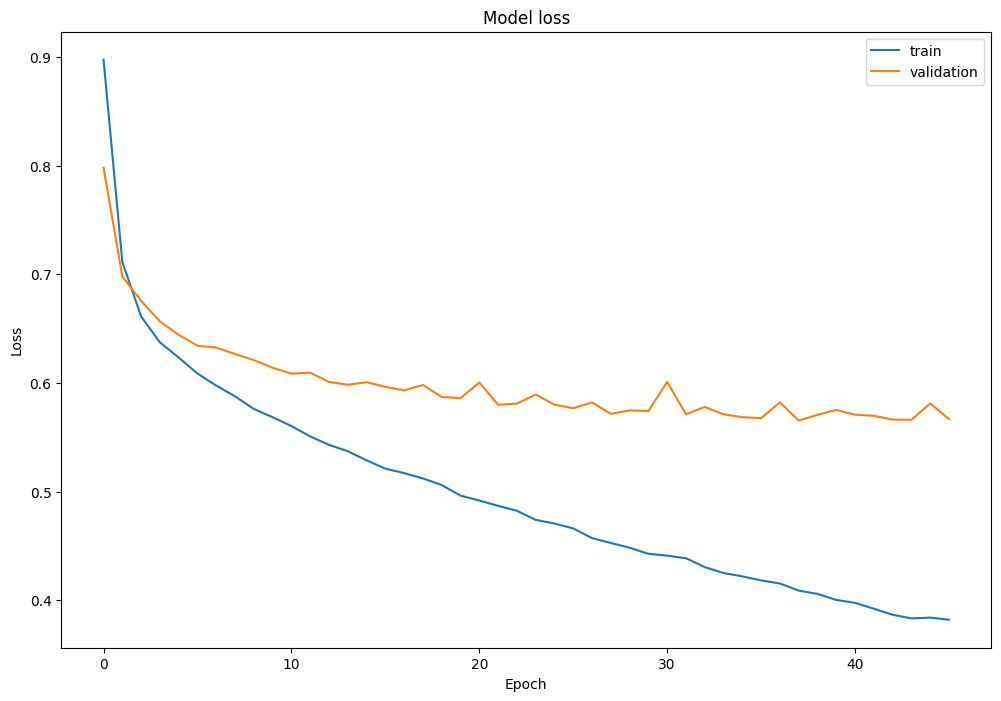

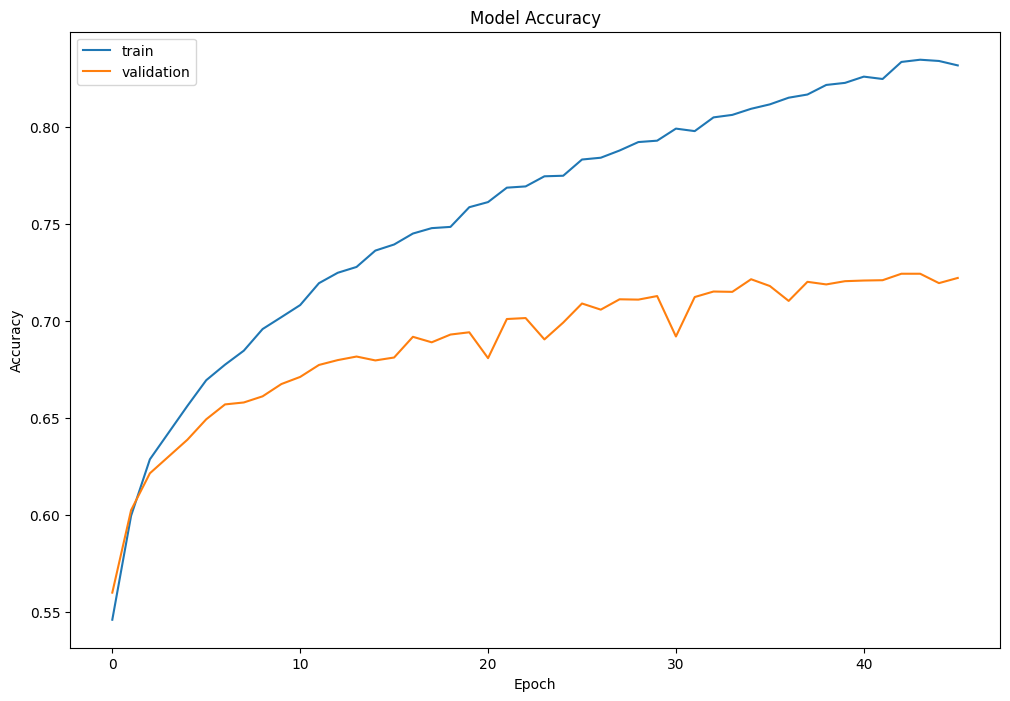

In [6]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [7]:
train_loss , train_accuracy = ConvModel.evaluate(X_train, Y_train_cat)
test_loss, test_accuracy = ConvModel.evaluate(X_test, Y_test_cat)

print(f"The train accuracy {train_accuracy}")
print(f"The test accuracy {test_accuracy}")

438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8327 - loss: 0.3899
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7203 - loss: 0.5655
The train accuracy 0.8327142596244812
The test accuracy 0.7203333377838135
